<img src="https://www.ceste.es/wp-content/uploads/2022/03/logotipo-ceste-escuela-internacional-de-negocios.svg" width="500"/>

# Procesamiento de lenguaje natural

## Transformers

Pablo Gómez Guerrero



## Contexto

Los transformers son un tipo de red neuronal especializada en analizar secuencias de datos, bien sean texto, sonido, series temporales, entre algunos ejemplos. Si recordáis en el notebook de "Spooky authors" generábamos texto (más bien lo continuábamos a partir de varias palabras) podemos decir que fue un preludio de lo que vamos a ver ahora con mayor detalle. Aquel era un modelo Seg2Seq, donde teníamos varios módulos:


*   Un encoder. Extraía la información relevante de nuestro texto formando los Embeddings
*   Un decoder. En nuestro caso era una capa lineal sencilla.
*   Un capa intermedia que en nuestro caso era una GRU causal (única dirección), que enriquecía la red añadiendo contexto.


<img src="https://miro.medium.com/v2/resize:fit:1400/1*qwJ1bOJEXjVUMsqEh0kuHA.png" />

En el caso de los transformers el componente más relevante y que le diferencia de respecto a los modelos que acabamos de ver son sus capas de atención. Concretamente con el paper ["Attention is all you need"](https://arxiv.org/pdf/1706.03762.pdf) se inaugura la exitosa arquitectura que está cambiando el panorama de la Inteligencia Artificial. Modelos como BERT, GPT3, Dall-e, ChatGPT o PaLM están bassados en esta potente arquitectura.

## Arquitectura

Vamos a observar su arquitectura por un momento.


<img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png" width="600"/>


Parte del escenario ya lo conocemos, un encoder, un decoder y el paso de contexto. No obstante, no sabemos qué son los módulo de atención.

Pero, primero de todo, ¿qué es la atención?
Anteriormente hemos visto que las arquitecturas Seq2Seq basadas en RNN pasaban el estado que se había procesado anteriormente a los siguientes elementos. Esto hacía que la red tuviera memoria. Concretamente en la frase.

El niño juega con **su** pelota.

La red entendía que **su** se refería al niño.

Sin embargo, en la frase.

El niño, ha bajado en un día lluvioso del mes de septiembre al campo de futbol municipal a jugar con **su** pelota.

Se ha estudiado que las redes recurrentes pierden la memoria cuando las frases son largas y no es capaz de asociar **su** a *El niño*.

Para esto es justamente para lo que añadiremos la atención.



## Mecanismos de atención

Los mecanismos de atención que son implementados para mantener esa memoria se explican de la siguiente forma. Imaginemos que tenemos la frase anterior:

```El niño, ha bajado en un día lluvioso del mes de septiembre al campo de futbol municipal a jugar con su pelota.```

Si obtenemos sus embeddings podemos saber qué relación podemos establecer entre los vectores que forman la frase. Por ejemplo, pelota con jugar,niño con su, mes con septiembre.

En realidad estas relaciones las podemos buscar con redes neuronales que nos devolverán las posibilidades que tiene de establecer relaciones unas palabra con otras. Es decir, ver la similitud entre vectores para saber si existe algún vector con compatibilidad.

Esta búsqueda de compatibilidad se calcula haciendo el producto escalar entre el vector **Query** y el vector **Key** y se conoce como vector de atención.
Ese vector lo que hace es añadirle esa falta de memoria a la red pues le indica cuál es el término que mejor compatibilidad tiene con otro dentro de un texto.

Ahora bien, seguimos necesitando una red neuronal que guarde la memoria para poder utilizar el mecanismo de atención sobre él. Pongamos que esa red es recurrente, a su resultado lo llamaremos vector **Valor** y mezclándolo con la relación entre *Query* y *Key* nos indica el peso de la relación de las palabras de una frase.

Sin embargo, llega 2017 con la publicación antes citada y quita las redes recurrentes de la ecuación e introduce el concepto de Transformer.



# Detector de sarcasmo con Transformers

In [ ]:
!pip install tensorflow
!pip install keras
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers import Embedding, Dropout
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [ ]:
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
data_1 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/CESTE_2023/data/Sarcasm_Headlines_Dataset.json", lines=True)
data_2 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/CESTE_2023/data/Sarcasm_Headlines_Dataset_v2.json", lines=True)
data =  pd.concat([data_1, data_2])
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
def clean_text(text):
    text = text.lower()

    # quizás esto no sea necesario pero es buena práctica
    # quitamos todas las urls que pueda haber en los textos
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))

    # ahora quitamos todos los emoticonos
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticonos
                           u"\U0001F300-\U0001F5FF"  # simbolos & pictogramas
                           u"\U0001F680-\U0001F6FF"  # transportes y simbolos de maps
                           u"\U0001F1E0-\U0001F1FF"  # banderas (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji.sub(r'', text)
    text = text.lower()

    #pasamos todo el texto de formas contraidas a extendidas
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [ ]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    head_lines = list()
    lines = df["headline"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenizamos (separamos en palabras) el texto ya limpio
        tokens = word_tokenize(line)
        # quitamos la puntuaciones
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # quitamos los posibles caracteres no alfabéticos
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # quitamos las stopwords
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

# Lo aplicamos a todo el dataset
head_lines = CleanTokenize(data)

In [ ]:
validation_split = 0.2
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines) # añadir vocabulario
sequences = tokenizer_obj.texts_to_sequences(head_lines) # secuencia de enteros

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post') # añadimos padding para tener la misma dimensión
sentiment =  data['is_sarcastic'].values # separamos las etiquetas

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  28657
vocab size - 28658


Hasta aquí todo es igual que en los notebooks anteriores.
Lo que vamos a hacer es crear nuestro Transformer.

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)#Dropout sirve para desactivar neuronas para hacer que la red generalice mejor, pequeños obstáculos
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
embed_dim = 100
heads = 4
neurons = 32
maxlen = 25
vocab_size = 28658

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 25)]              0         
                                                                 
 token_and_position_embeddin  (None, 25, 100)          2868300   
 g_4 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_encoder_4 (Tran  (None, 25, 100)          168232    
 sformerEncoder)                                                 
                                                                 
 global_average_pooling1d_4   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_14 (Dropout)        (None, 100)               0   

## Early Stop & learning rate reduction

Aquí vamos a introducir 2 conceptos nuevos que vimos de pasada al principio de la unidad que son el early stop y la reducción del learning rate cuando el entrenamiento no mejora. Veremos que estas estrategias de entrenamiento son muy interesantes para hacer entrenamientos con muchas epocs y que pueden dilatarse en el tiempo

1. **Early stop**. Se trata de fijarse en un valor de entrenamiento (loss, acc) e ir viendo si mejora. Le añadimos una constante de paciencia (patience) y en el caso que durante las epocs=paciencia el valor que fijamos (loss, acc) no mejore detenemos el entrenamiento.
2. **Learning Rate Reduction**. Otro ejemplo es cuando un entrenamiento se queda atascado y no mejora, se pueden aplicar este tipo de estrategias para reducir el learning rate paulatinamente, este caso también tiene una constante paciencia.

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 4, verbose = 1)
# Si en 4 eppochs no ha mejorado el valor que he monitorizado (0.001) paro el entrenamiento

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                           patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
history = model.fit(X_train_pad,y_train,
                    validation_data=(X_test_pad,y_test),
                    epochs=25,
                    batch_size=32,
                    callbacks=[earlystopping, learning_rate_reduction])

Epoch 1/25
1384/1384 [==============================] - 153s 108ms/step - loss: 0.4405 - acc: 0.7828 - val_loss: 0.2789 - val_acc: 0.8872 - lr: 3.0000e-04
Epoch 2/25
1384/1384 [==============================] - 148s 107ms/step - loss: 0.1812 - acc: 0.9306 - val_loss: 0.2519 - val_acc: 0.9103 - lr: 3.0000e-04
Epoch 3/25
1384/1384 [==============================] - 148s 107ms/step - loss: 0.0908 - acc: 0.9690 - val_loss: 0.2183 - val_acc: 0.9405 - lr: 3.0000e-04
Epoch 4/25
1384/1384 [==============================] - 145s 105ms/step - loss: 0.0474 - acc: 0.9848 - val_loss: 0.2256 - val_acc: 0.9488 - lr: 3.0000e-04
Epoch 5/25
1384/1384 [==============================] - 144s 104ms/step - loss: 0.0269 - acc: 0.9916 - val_loss: 0.2834 - val_acc: 0.9472 - lr: 3.0000e-04
Epoch 6/25
1384/1384 [==============================] - ETA: 0s - loss: 0.0172 - acc: 0.9945
Epoch 6: ReduceLROnPlateau reducing learning rate to 6.000000284984708e-05.
1384/1384 [==============================] - 149s 107ms/

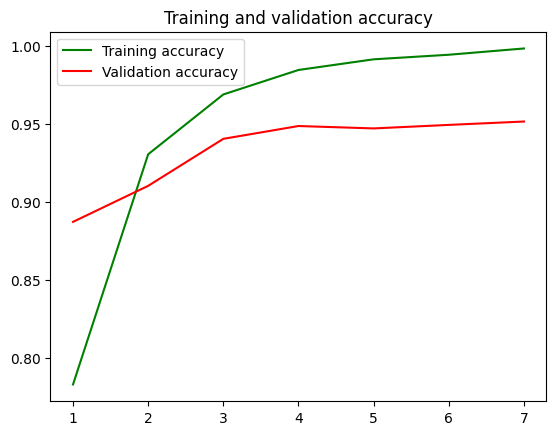

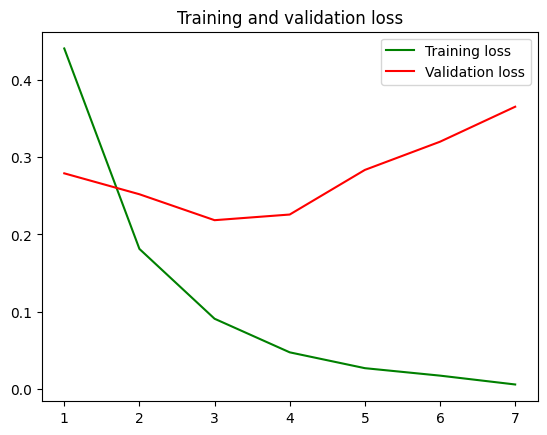

In [ ]:
# Resultados de entrenamiento
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!"
    else: return "It's not a sarcasm."

In [ ]:
predict_sarcasm("I was depressed. He asked me to be happy. I am not depressed anymore.")

1/1 [==============================] - 0s 205ms/step


"It's a sarcasm!"

In [ ]:
predict_sarcasm("You just broke my car window. Great job.")

1/1 [==============================] - 0s 44ms/step


"It's a sarcasm!"

In [ ]:
predict_sarcasm("You just saved my dog's life. Thanks a million.")

1/1 [==============================] - 0s 30ms/step


"It's not a sarcasm."

In [ ]:
predict_sarcasm("I want a million dollars!")

1/1 [==============================] - 0s 23ms/step


"It's not a sarcasm."

In [ ]:
predict_sarcasm("I want a million dollars in my pocket!")

1/1 [==============================] - 0s 57ms/step


"It's a sarcasm!"

### Errores

In [ ]:
predict_sarcasm("His name is Bob. He is a nice person.")

1/1 [==============================] - 0s 24ms/step


"It's a sarcasm!"

In [ ]:
predict_sarcasm("Sarcasm is very easy to detect.")

1/1 [==============================] - 0s 24ms/step


"It's not a sarcasm."